In [5]:
%pip install torch torchshow insightface deepface> /tmp/1

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import glob
from PIL import Image
import torch
import numpy
import torch.nn.functional as tnf
import torchshow as ts
from deepface import DeepFace
from insightface.app import FaceAnalysis
from PIL import Image
from PIL import ImageDraw
import numpy as np

In [9]:
!mkdir -p data/lfw
!(cd data/lfw; wget -nc http://vis-www.cs.umass.edu/lfw/lfw-a.tgz)
#!(cd data/lfw; tar xf lfw-a.tgz)

File ‘lfw-a.tgz’ already there; not retrieving.



In [66]:
%%time
files = glob.glob("data/lfw/lfw/*/*")
subset = sorted(files)[0:512]

CPU times: user 0 ns, sys: 7.15 ms, total: 7.15 ms
Wall time: 6.43 ms


In [67]:
# 1.5 seconds without excluding landmarks; 0.4 seconds excluding them for an image with 8 faces.
class InsightFace_Wrapper:
    
    def __init__(self,exclude=['landmark_3d_68', 'landmark_2d_106', 'genderage' ]):
        self.app = FaceAnalysis(ctx_id=0, providers=['CUDAExecutionProvider','CPUExecutionProvider'])
        self.app.prepare(ctx_id=0, det_size=(640,640))
        for m in exclude or []:
            del(self.app.models[m])
            
    def analyze(self,img:Image, max_num=0):
        img_np = np.asarray(img.convert('RGB'))
        res = self.app.get(img_np,max_num)
        return res

if not 'ifw' in locals():
    ifw = InsightFace_Wrapper()
    
def get_first_insightface_embedding(f):
    try:
        img = Image.open(f)
        a = ifw.analyze(img)
        return a[0]['embedding']
    except:
        pass
    return None
    return [0]*512

def visualize_embeddings(embeddings):
    e2 = [e for e in embeddings if e is not None]
    t = torch.tensor(numpy.array(e2))
    t_n = tnf.normalize(t,dim=1)
    ts.show(t_n @ t_n.T)
def visualize_embeddings2(embeddings): 
    e2 = [e for e in embeddings if e is not None]
    t = torch.tensor(numpy.array(e2))
    tavg = torch.mean(t,dim=0)
    t = t - tavg
    t_n = tnf.normalize(t,dim=1)
    ts.show(t_n @ t_n.T)


In [68]:
# https://github.com/serengil/deepface/blob/master/deepface/DeepFace.py#L59

deepface_model_sizes = {
        "VGG-Face":2622,
        "OpenFace":128,
        "Facenet":128,
        "Facenet512":512,
        "DeepFace":4096,
        "DeepID":160,
        "ArcFace":512,
        "SFace":128,
}
deepface_models = list(deepface_model_sizes.keys())

if test_models := False:
    for m in deepface_models:
        print(m)
        print(str(DeepFace.represent(img_path=subset[0],model_name=m))[0:100])

def get_deepface_embedding(f,m):
    try:
        r = DeepFace.represent(img_path=f,model_name=m)
        if len(r)>0:
            return np.array(r[0]['embedding'])
    except Exception as e:
        pass
    #return np.array([0]*deepface_model_sizes[m])
    return None


In [69]:
def try_deepface_model(deepface_idx):
    global embeddings
    print(deepface_models[deepface_idx])
    embeddings = [get_deepface_embedding(f,deepface_models[deepface_idx]) for f in subset]
    visualize_embeddings(embeddings)
    #len(embeddings[0])

InsightFace
CPU times: user 22min 55s, sys: 2.77 s, total: 22min 58s
Wall time: 1min 28s


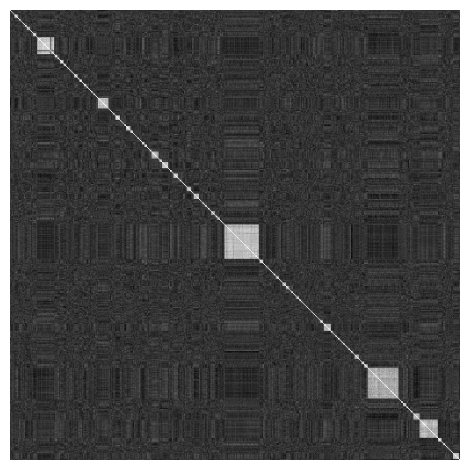

In [70]:
%%time
print("InsightFace")
embeddings = [get_first_insightface_embedding(f) for f in subset]
visualize_embeddings(embeddings)

VGG-Face
CPU times: user 8min 46s, sys: 11.6 s, total: 8min 58s
Wall time: 1min 13s


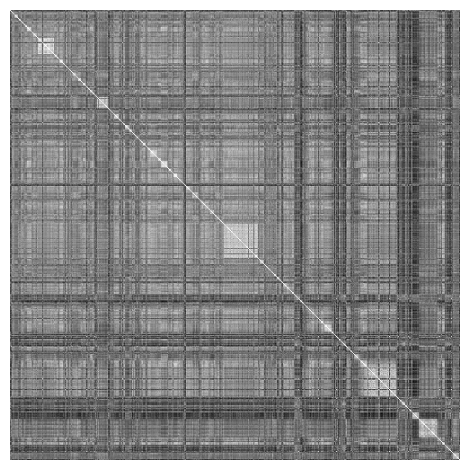

In [71]:
%%time
try_deepface_model(0)

VGG-Face
CPU times: user 8min 46s, sys: 12.7 s, total: 8min 59s
Wall time: 1min 14s


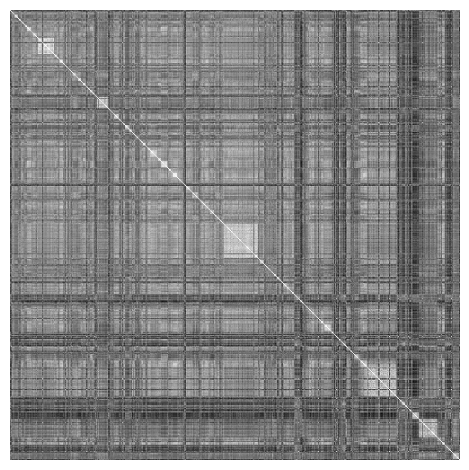

In [72]:
%%time
try_deepface_model(0)

OpenFace
CPU times: user 59.6 s, sys: 7.76 s, total: 1min 7s
Wall time: 29.3 s


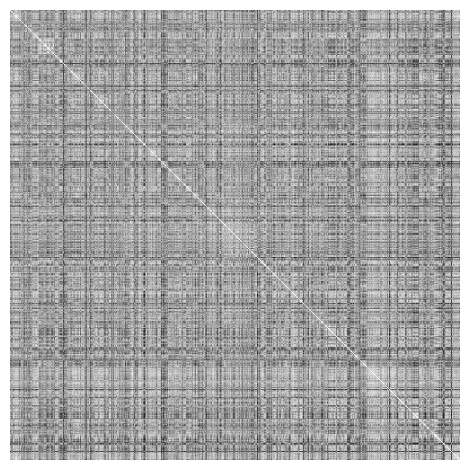

In [73]:
%%time
try_deepface_model(1)

Facenet
CPU times: user 1min 57s, sys: 9.67 s, total: 2min 6s
Wall time: 35.7 s


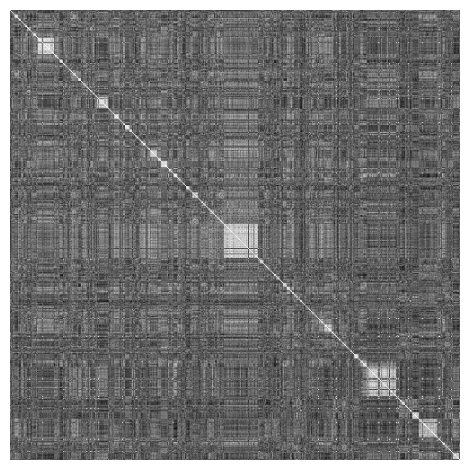

In [74]:
%%time
try_deepface_model(2)

Facenet512
CPU times: user 1min 55s, sys: 10.3 s, total: 2min 5s
Wall time: 36.1 s


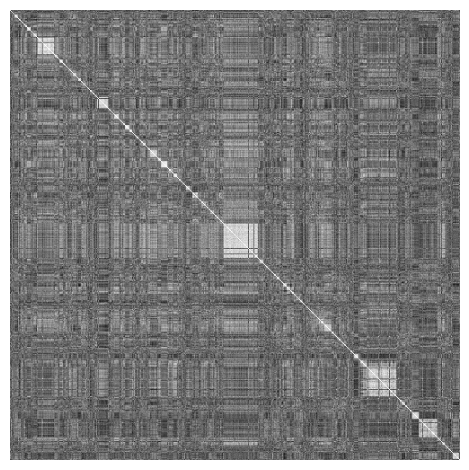

In [75]:
%%time
try_deepface_model(3)

DeepFace
CPU times: user 3min 5s, sys: 8.88 s, total: 3min 14s
Wall time: 40.4 s


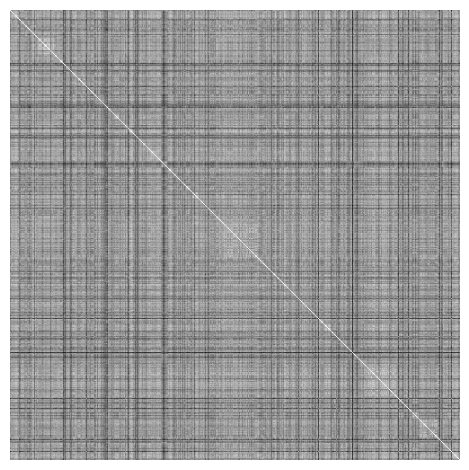

In [76]:
%%time
try_deepface_model(4)

DeepID
CPU times: user 49 s, sys: 7.49 s, total: 56.5 s
Wall time: 26.2 s


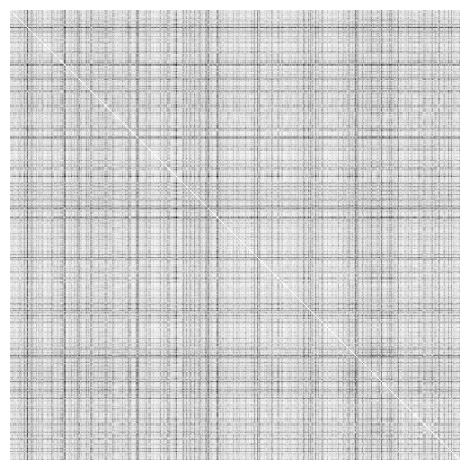

In [77]:
%%time
try_deepface_model(5)

ArcFace
CPU times: user 3min 48s, sys: 12.6 s, total: 4min 1s
Wall time: 43.8 s


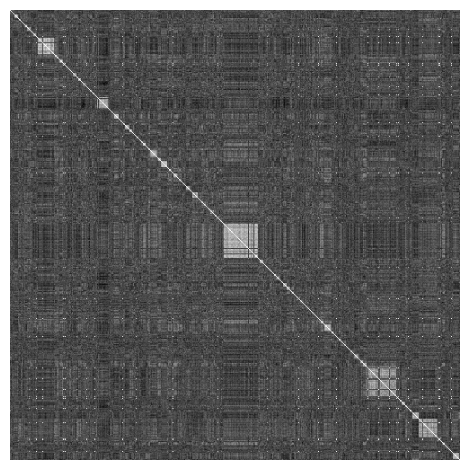

In [79]:
%%time
try_deepface_model(6)

SFace
CPU times: user 1min 21s, sys: 22.9 s, total: 1min 44s
Wall time: 13.2 s


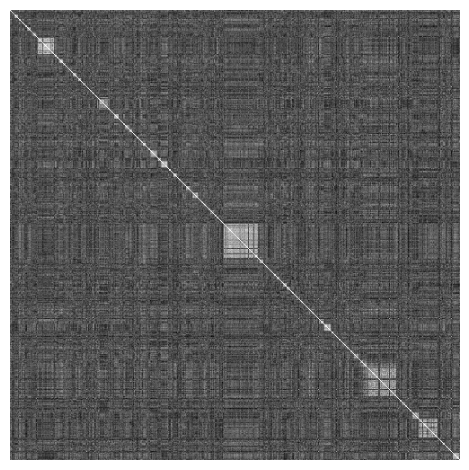

In [80]:
%%time
try_deepface_model(7)

In [82]:
subset

['data/lfw/lfw/AJ_Cook/AJ_Cook_0001.jpg',
 'data/lfw/lfw/AJ_Lamas/AJ_Lamas_0001.jpg',
 'data/lfw/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg',
 'data/lfw/lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg',
 'data/lfw/lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg',
 'data/lfw/lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg',
 'data/lfw/lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg',
 'data/lfw/lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg',
 'data/lfw/lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg',
 'data/lfw/lfw/Aaron_Pena/Aaron_Pena_0001.jpg',
 'data/lfw/lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg',
 'data/lfw/lfw/Aaron_Sorkin/Aaron_Sorkin_0002.jpg',
 'data/lfw/lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg',
 'data/lfw/lfw/Abba_Eban/Abba_Eban_0001.jpg',
 'data/lfw/lfw/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg',
 'data/lfw/lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg',
 'data/lfw/lfw/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg',
 'data/lfw/lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg',
 'data/lfw/lfw/Abdel_Nasser_As